In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])  # Set the desired memory limit (in MB)
    except RuntimeError as e:
        print(e)

In [3]:
import tensorflow as tf
tf.keras.mixed_precision.set_global_policy('mixed_float16')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650 Ti, compute capability 7.5


In [4]:
# Define the SGAM layer
def sgam_layer(inputs):
    _, height, width, filters = inputs.shape.as_list()
    
    x = layers.Reshape((height * width, filters))(inputs)
    x = layers.Dense(units=filters, activation='sigmoid')(x)
    x = layers.Reshape((height, width, filters))(x)
    
    return x

In [5]:
def preprocess_images(images):
    # Resize images to 64x64
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, (64, 64))
        resized_images.append(resized_image)
    # Normalize pixel values
    normalized_images = np.array(resized_images) / 255.0
    return normalized_images


In [6]:
# Create the encoder model
def create_encoder(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # First set of DSC layers
    x1 = layers.SeparableConv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    x2 = layers.SeparableConv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(inputs)
    x3 = layers.SeparableConv2D(filters=64, kernel_size=(7, 7), padding='same', activation='relu')(inputs)
    
    # Concatenate and apply SGAM
    x = layers.concatenate([x1, x2, x3])
    x = sgam_layer(x)
    
    # Downsample
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Second set of DSC layers
    x1 = layers.SeparableConv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x2 = layers.SeparableConv2D(filters=128, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x3 = layers.SeparableConv2D(filters=128, kernel_size=(7, 7), padding='same', activation='relu')(x)
    
    # Concatenate and apply SGAM
    x = layers.concatenate([x1, x2, x3])
    x = sgam_layer(x)
    
    # Downsample
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Third set of DSC layers
    x1 = layers.SeparableConv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x2 = layers.SeparableConv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x3 = layers.SeparableConv2D(filters=256, kernel_size=(7, 7), padding='same', activation='relu')(x)
    
    # Concatenate and apply SGAM
    x = layers.concatenate([x1, x2, x3])
    x = sgam_layer(x)
    
    # Downsample
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Final DSC layer
    x = layers.SeparableConv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [7]:
# Create the decoder model
def create_decoder(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # DSC layer and upsampling
    x = layers.SeparableConv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    x = layers.UpSampling2D(size=(2, 2))(x)

    # SGAM layer
    x = sgam_layer(x)

    # Second set of DSC layers
    x1 = layers.SeparableConv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x2 = layers.SeparableConv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x3 = layers.SeparableConv2D(filters=256, kernel_size=(7, 7), padding='same', activation='relu')(x)

    # Concatenate and upsample
    x = layers.concatenate([x1, x2, x3])
    x = layers.UpSampling2D(size=(2, 2))(x)

    # SGAM layer
    x = sgam_layer(x)

    # Third set of DSC layers
    x1 = layers.SeparableConv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x2 = layers.SeparableConv2D(filters=128, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x3 = layers.SeparableConv2D(filters=128, kernel_size=(7, 7), padding='same', activation='relu')(x)

    # Concatenate and upsample
    x = layers.concatenate([x1, x2, x3])
    x = layers.UpSampling2D(size=(2, 2))(x)

    # SGAM layer
    x = sgam_layer(x)

    # Fourth set of DSC layers
    x1 = layers.SeparableConv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x2 = layers.SeparableConv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x3 = layers.SeparableConv2D(filters=64, kernel_size=(7, 7), padding='same', activation='relu')(x)

    # Concatenate and upsample
    x = layers.concatenate([x1, x2, x3])
    x = layers.UpSampling2D(size=(2, 2))(x)

    # SGAM layer
    x = sgam_layer(x)

    # Final DSC layer
    outputs = layers.Conv2D(filters=3, kernel_size=(3, 3), padding='same', activation='sigmoid')(x)

    # Resize the output to the desired shape
    outputs = tf.image.resize(outputs, (64, 64))

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [8]:
# Create the forgery detection model
def create_forgery_model(input_shape):
    encoder = create_encoder(input_shape)
    decoder = create_decoder(encoder.output_shape[1:])

    inputs = tf.keras.Input(shape=input_shape)
    encoded = encoder(inputs)
    decoded = decoder(encoded)

    return tf.keras.Model(inputs=inputs, outputs=decoded)

In [9]:
import os
import cv2
import numpy as np
from tensorflow import keras

dataset_path = 'D:/VIT/SEM X/Image Forgery/FD3'
train_path = os.path.join(dataset_path, 'Train')
test_path = os.path.join(dataset_path, 'Test')

def load_images_from_folder(folder_path, limit=None):
    images = []
    count = 0
    for filename in os.listdir(folder_path):
        if limit is not None and count >= limit:
            break
        image = cv2.imread(os.path.join(folder_path, filename))
        if image is not None:
            images.append(image)
            count += 1
    return images

# Load training images
train_original_path = os.path.join(train_path, 'img')
train_forged_path = os.path.join(train_path, 'gt')
X_train_original = load_images_from_folder(train_original_path, limit=10)
X_train_forged = load_images_from_folder(train_forged_path, limit=10)
X_train_original = preprocess_images(X_train_original)
X_train_forged = preprocess_images(X_train_forged)
X_train = np.concatenate((X_train_original, X_train_forged), axis=0)

# Load testing images
test_original_path = os.path.join(test_path, 'img')
test_forged_path = os.path.join(test_path, 'gt')
X_test_original = load_images_from_folder(test_original_path, limit=10)
X_test_forged = load_images_from_folder(test_forged_path, limit=10)
X_test_original = preprocess_images(X_test_original)
X_test_forged = preprocess_images(X_test_forged)
X_test = np.concatenate((X_test_original, X_test_forged), axis=0)

# Create labels for training and testing images
y_train_original = np.zeros(len(X_train_original))
y_train_forged = np.ones(len(X_train_forged))
y_train = np.concatenate((y_train_original, y_train_forged))

y_test_original = np.zeros(len(X_test_original))
y_test_forged = np.ones(len(X_test_forged))
y_test = np.concatenate((y_test_original, y_test_forged))

# Shuffle the training data
shuffle_indices = np.random.permutation(len(X_train))
X_train = X_train[shuffle_indices]
y_train = y_train[shuffle_indices]

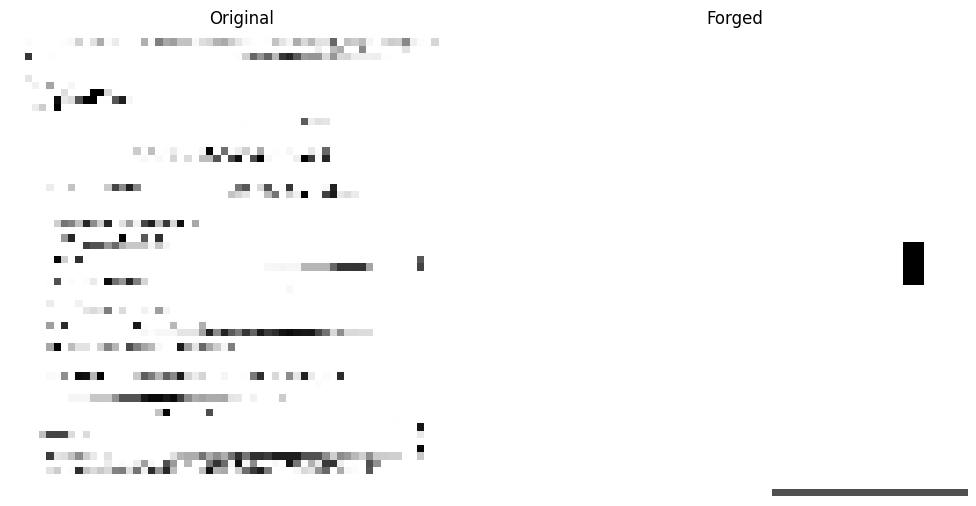

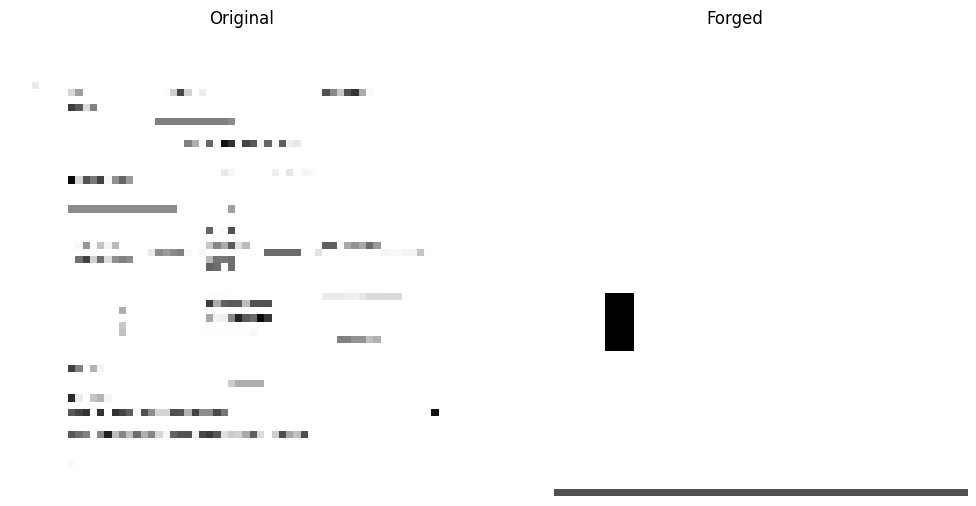

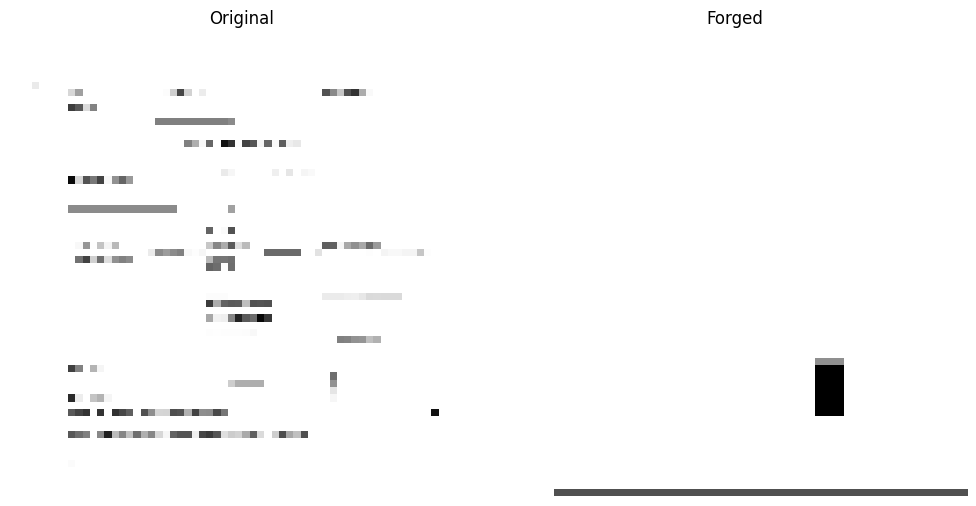

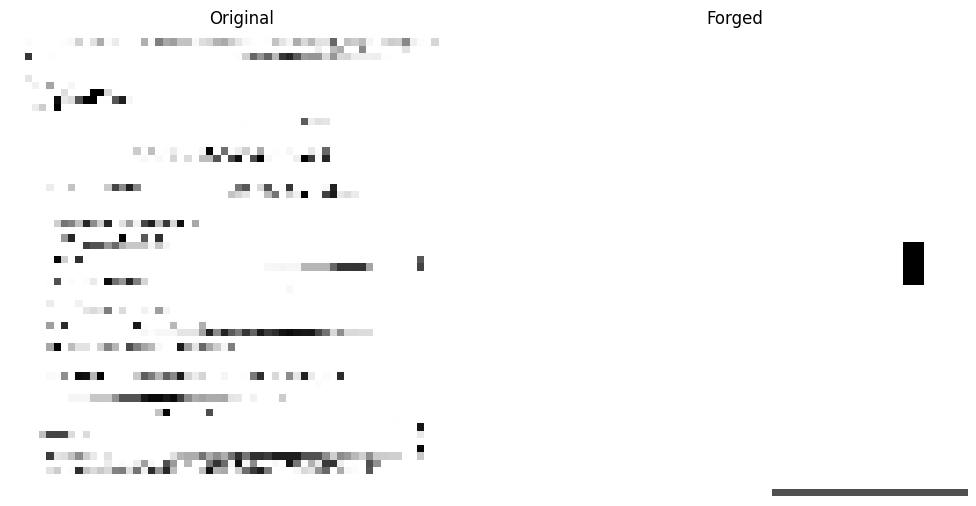

In [10]:
# Print some sample inputs
num_samples = 5
sample_indices = np.random.randint(len(X_train), size=num_samples)

for i in sample_indices:
    if i >= len(X_train_original):
        continue  # Skip this iteration if the index is out of bounds
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(X_train_original[i])
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    if i >= len(X_train_forged):
        continue  # Skip this iteration if the index is out of bounds
    axes[1].imshow(X_train_forged[i])
    axes[1].set_title('Forged')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()


In [11]:
for image in X_test:
    print(image.shape)

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


In [12]:
# Create the forgery detection model
model = create_forgery_model(input_shape=(64, 64, 3))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mse'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
model (Functional)           (None, 8, 8, 512)         1594745   
_________________________________________________________________
model_1 (Functional)         (None, 64, 64, 3)         2211907   
Total params: 3,806,652
Trainable params: 3,806,652
Non-trainable params: 0
_________________________________________________________________


In [13]:
from keras.preprocessing.image import ImageDataGenerator

# Create image data generator
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create training data generator
train_generator = datagen.flow(X_train, y_train, batch_size=4)

# Train the model using the generator
model.fit(train_generator, epochs=10, verbose=1)

Epoch 1/10


InvalidArgumentError:  required broadcastable shapes
	 [[node mean_squared_error/SquaredDifference (defined at \AppData\Local\Temp\ipykernel_10492\1830123420.py:10) ]] [Op:__inference_train_function_8075]

Function call stack:
train_function


In [ ]:
from keras.callbacks import ModelCheckpoint

# Define the checkpoint filepath
checkpoint_filepath = 'model_checkpoint.h5'

# Create model checkpoint callback
checkpoint = ModelCheckpoint(checkpoint_filepath, save_weights_only=True, save_best_only=True)

# Train the model with the checkpoint callback
model.fit(X_train, y_train, batch_size=4, epochs=10, callbacks=[checkpoint])


In [ ]:
# Evaluate the model on the testing set
evaluation = model.evaluate(X_test_preprocessed, y_test_preprocessed)
print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])
print("Evaluation MSE:", evaluation[2])

In [ ]:
# Perform predictions on the testing set
predictions = model.predict(X_test_preprocessed)

# Threshold the predictions to obtain binary masks
threshold = 0.5
binary_predictions = (predictions > threshold).astype(np.uint8)

# Flatten the masks and predictions for computing accuracy, precision, recall, and F1 score
flatten_masks = y_test_preprocessed.flatten()
flatten_predictions = binary_predictions.flatten()

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(flatten_masks, flatten_predictions)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(flatten_masks, flatten_predictions)
print("Precision:", precision)

# Calculate recall
recall = recall_score(flatten_masks, flatten_predictions)
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(flatten_masks, flatten_predictions)
print("F1 Score:", f1)

# Compute Intersection over Union (IOU)
iou = tf.keras.metrics.MeanIoU(num_classes=2)
iou.update_state(flatten_masks, flatten_predictions)
iou_result = iou.result().numpy()
print("IOU:", iou_result)

# Compute Dice coefficient
dice_coefficient = (2 * iou_result) / (iou_result + 1)
print("Dice Coefficient:", dice_coefficient)

In [ ]:
# Plot training history
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [ ]:
# Plot sample images with ground truth masks and predictions
num_samples = 5

for i in range(num_samples):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(X_test_preprocessed[i])
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(y_test_preprocessed[i], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(binary_predictions[i], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()